In [82]:
import pandas as pd
from tqdm import tqdm
import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.chdir(r"D://Proposal_Defense//Simulations")
# from Utils.Script_utils import get_data_splits, first_LSTM_training, get_data_splits_old_algo
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [83]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

No GPU found


In [84]:
import matplotlib.pyplot as plt

import pickle

In [85]:
model_cbow = gensim.models.word2vec.Word2Vec.load(r"..//Data_Generation//word2vec_sg")

In [86]:
# data["high_level_substr"].value_counts()

In [87]:
# data.head()

In [88]:
reps = 50

In [89]:
with open('..//Data_Generation//Data//train_valid_test_splits_50.pkl', 'rb') as f:
    catch = pickle.load(f)  

In [90]:
with open('..//Data_Generation//LSTM_Heavy_Dropout//heavy_dropout_first_lstm.pkl', 'rb') as f:
    first_lstm = pickle.load(f)  

    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_train_logits.pkl', 'rb') as f:
#     catch_train_logits = (pickle.load(f))    

# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_valid_logits.pkl', 'rb') as f:
#     catch_valid_logits = (pickle.load( f))      
    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_test_logits.pkl', 'rb') as f:
#     catch_test_logits = (pickle.load( f))      
    

In [91]:
def ann(hidden = 10): 
    input_layer = tf.keras.layers.Input(shape = (X_train_word2vec.shape[1]))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [92]:
h1, h2 = 16,16

In [93]:
X_train_word2vec = first_lstm[0][3].numpy()

In [94]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [95]:
ann_15.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                416       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [96]:
X_train_word2vec = model_cbow.wv.vectors

In [97]:
ann_20 = ann(h2)



# ann_20.summary()



In [98]:
total_weights_1 = ann_15.count_params()

In [99]:
total_weights_2 = ann_20.count_params()

In [100]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [101]:
total_weights

1267

In [102]:
## batch size
batch_size = 32

In [103]:
# var_weights = 0.08
# var_targets = 0.08

In [104]:
from scipy.stats import multivariate_normal as mvn

In [105]:
from scipy.stats import invgamma, norm

In [106]:
from tqdm.notebook import tqdm

In [107]:
threshold = 5

In [108]:
import random

In [109]:
lr = 0.1

In [110]:
import numpy as np

In [111]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [112]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [113]:
import time

In [114]:
from scipy.stats import multivariate_normal as mvn

In [115]:
var_weights =16
# var_weights_vec = 4
# var_targets = 0.04
# var_weights = 2

In [116]:
from scipy.stats import multivariate_normal as mvn

In [117]:
reduction = 8
# reduction = 10

In [118]:
shape_needed = (total_weights + 2*batch_size*1 + 1 + (total_weights_2 - total_weights_1))//reduction

In [119]:
size_ens = shape_needed

In [120]:
size_ens = int(size_ens)

In [121]:
size_ens

216

In [122]:
# train_fudged_probs

In [123]:
import matplotlib.pyplot as plt

In [124]:
from scipy.special import expit

In [125]:
# catch1[0][0]

In [126]:
# catch_train_logits_second[0]

In [127]:
from datetime import datetime

In [128]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [129]:
from scipy.stats import gamma

In [130]:
# second_lstm[0]

In [131]:
# reduction = 8
# var_weights = 1

In [132]:
# cur_idx = 16
# np.log(catch_test_probs[cur_idx]/(1-catch_test_probs[cur_idx]))

In [133]:
# catch_preds_df

In [134]:
# ids = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] < 0.5]
# ids_more = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] > 0.5]

In [135]:
# ids_more

In [136]:
import plotly.express as px

In [137]:
import seaborn as sns

In [138]:
use_cores = multiprocessing.cpu_count()-1

In [139]:
use_cores = 15

In [140]:
# threshold = 200
# cutoff_threshold = 70

In [141]:
catch1 = first_lstm

In [63]:
from datetime import datetime

In [64]:
def rep_one_real_world(idx, inflation_factor = 0.2, cutoff = 100): 
    catch_1 = []
    catch_2 = []
    catch_3 = []
    catch_4 = []
    catch_5 = []
#     from scipy.special import expit
    patience_smaller = 0
# patience_bigger = 0

#     best_train_acc = 0
#     best_valid_acc = 1000

#     best_valid_mae = 10
    
    best_train_mae = 100
    
    X_train_logits = np.vstack((catch1[idx][0], catch1[idx][1]))
#     X_train_logits = catch_train_logits_second[idx]
    
    
    X_test_logits = catch1[idx][2]
    
    ## create training batch chunks
    train_idx = list(range(0, X_train_logits.shape[0]))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    
    log_sigma_points_1 = (np.log(gamma(100, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = catch1[idx][3].numpy()
    valid_lstm = catch1[idx][4].numpy()
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = catch1[idx][5].numpy()
 

    train_doc2vec = []
    for seq in catch[idx][0]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        train_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    train_doc2vec = np.array(train_doc2vec)
    
    valid_doc2vec = []
    for seq in catch[idx][1]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        valid_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    valid_doc2vec = np.array(valid_doc2vec)
    
    test_doc2vec = []
    for seq in catch[idx][2]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        test_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    test_doc2vec = np.array(test_doc2vec)    
    
    
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm, test_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec, test_doc2vec))
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    
    
    train_valid_lstm = np.vstack((train_lstm, valid_lstm))
    train_valid_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    

    # best_width_train = 100
    
    # threshold_achieved = False
    # satisfactory = False
    # satisfactory_counter = 0
    
    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in range(0,500):

        for batch_idx in batch_chunks:

            batch_data = train_valid_lstm[batch_idx,:]
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data.shape)
            batch_targets = X_train_logits[batch_idx,:]
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            
            
            
            
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_valid_lstm, train_valid_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_valid_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            
            
            
#             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
            initial_targets_softmax = expit(initial_targets)
        
            initial_softmax_train = initial_targets_softmax
            
            initial_targets_train_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = expit(X_train_logits)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel()))
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_lstm, test_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            initial_targets_softmax = expit(initial_targets)    
            
            initial_targets_test_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            catch_test_probs = expit(X_test_logits)
            
            ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
               

                        
            coverage_test = np.mean(ind_test.ravel())    

            # initial_targets_test_mean = initial_targets_train.mean(0)
    
            
            
            test_mae = np.mean(np.abs(catch_test_probs.ravel() - initial_targets_test_mean.ravel()))
       
        # print(avg_width_train, best_train_width, coverage_train)
        
#         print("epoch "+ str(iter1))
#         print("patience "+ str(patience_smaller))
#         print("train mae is " + str(train_mae))
#         print("test mae is " + str(test_mae))
        
#         print("train coverage is "+ str(coverage_train))
#         print("train width is " + str(avg_width_train))        
#         print("test coverage is "+ str(coverage_test))
#         print("test width is " + str(avg_width))
        # print("lstm weight is " + str(np.mean(complement)))
        # print("threshold " + str(threshold_achieved))
              
    
        if (train_mae < best_train_mae) : 
#             cur_best_train_width = avg_width_train
#             cur_best_test_width = avg_width

#             cur_best_train_coverage = coverage_train
#             cur_best_test_coverage = coverage_test 
#             cur_best_lstm_weight = np.mean(complement)
            best_train_mae = train_mae
            best_test_mae = test_mae
            exit_iter_no_thresh = iter1
            best_test_preds = initial_targets_softmax
            patience_smaller = 0
            best_train_coverage = coverage_train
            best_test_coverage = coverage_test
            best_train_width = avg_width_train
            best_test_width = avg_width
            # satisfactory = True
            
        else:
            patience_smaller+=1
            
        if patience_smaller > threshold:
            
            break
            
        if (patience_smaller > cutoff_threshold) & (train_mae < 0.05):
            
            break
            
            
    print(best_test_mae,best_test_coverage, best_test_width, flush = True)
    end = datetime.now()
    total = (end-start)
    time_taken = total.seconds/60.0
    return best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width,  exit_iter_no_thresh, time_taken, best_test_preds
        
    # print("something went awry", flush = True)

In [65]:
threshold = 200

In [66]:
cutoff_threshold = 100

In [67]:
doc2vec_dbow = gensim.models.doc2vec.Doc2Vec.load(r"..//Data_Generation//doc2vec_dbow")

In [159]:
# rep_one_real_world(30)

In [160]:
catch_coverages = Parallel(n_jobs=15, verbose = 10, backend = "loky")(delayed(rep_one_real_world)(i) for i in range(reps))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


0.04220556725972105 1.0 0.26768142489431
0.017723596532208015 0.875 0.08791603866408579


[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  1.7min


0.041198711247626287 0.875 0.1211352449309013
0.009322058802654794 0.75 0.036503378205176865
0.018115627396741444 1.0 0.26229562247269256
0.05234948579861172 0.875 0.0983827390628242
0.006713520754090309 1.0 0.06925228771295544
0.012494491427079504 1.0 0.11139036568453749
0.010651772901558613 1.0 0.1744083389771422
0.008679524853165033 1.0 0.05975900079789826
0.020704801192194994 1.0 0.15623778117636786


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  2.4min


0.0076312419580697 1.0 0.07306754503211495
0.010774446547779214 0.875 0.04548896965043528
0.02656953200244385 1.0 0.2077143382406997
0.028017600323405865 1.0 0.15581193034402818
0.04010283127148215 1.0 0.3761044659036579
0.023420088351658222 0.625 0.05270641295126113
0.009169833288815798 1.0 0.05442887745222522
0.018428666951133457 1.0 0.15087727567307413
0.022460952090352017 1.0 0.1593511961352862


[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  4.2min


0.023610445575075766 1.0 0.2691294856360063
0.013090361907571277 0.75 0.04761742955160903
0.029018449962230346 1.0 0.16930986544855003
0.01723179461061094 1.0 0.15043987621602084
0.025416196312430972 1.0 0.1631438291116858
0.07374186557583572 0.875 0.2523877636357468


/tmp/ipykernel_1361131/2467791455.py:4: RuntimeWarning: overflow encountered in exp


0.02689024722435047 0.875 0.09437477230369365


[Parallel(n_jobs=15)]: Done  27 out of  50 | elapsed:  4.9min remaining:  4.2min


0.025802891212918275 1.0 0.15885750942594373
0.017521470825835363 1.0 0.10992493270515803
0.017386469715590873 0.375 0.03160146688254853
0.019997683594484852 1.0 0.1039198691566258
0.02244118517606142 0.875 0.0907715670487217
0.02036274833951642 1.0 0.2150138554448195


[Parallel(n_jobs=15)]: Done  33 out of  50 | elapsed:  6.4min remaining:  3.3min


0.01776112931019711 1.0 0.1445393818246397
0.007303188414172644 1.0 0.04633315173671862
0.031383951982181676 0.5 0.08636086934913256
0.01666194249507853 1.0 0.271841062707724
0.009836648347765863 1.0 0.1305611635242977
0.0176422700454237 1.0 0.1033834688894055


[Parallel(n_jobs=15)]: Done  39 out of  50 | elapsed:  7.1min remaining:  2.0min


0.005006956821190317 1.0 0.03384073190593805
0.0015165663379648198 1.0 0.008088405270658133
0.007489111534346654 0.375 0.008923587298231953
0.016347425556634425 0.875 0.10287588805249546
0.018375711358911515 1.0 0.15537796147441318
0.016785359846740327 1.0 0.22936330964020826


[Parallel(n_jobs=15)]: Done  45 out of  50 | elapsed:  8.1min remaining:   54.0s


0.01618825225428469 1.0 0.10113562902926557
0.013523541239381657 0.625 0.02144169812759938
0.014237219653920826 1.0 0.057848564313366144
0.022790666277425507 0.375 0.031403165868082505
0.009822958053664108 0.875 0.04044407096621473


[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed: 11.4min finished


In [161]:
# catch_coverages

In [162]:
check = pd.DataFrame(catch_coverages).iloc[:,:-1]

In [163]:
# check

In [164]:
# check

In [165]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [166]:
check

,0,1,2,3,4,5,6,7
0,0.009145,0.052349,1.000000,0.090229,0.875,0.098383,67,1.900000
1,0.015074,0.018116,1.000000,0.270699,1.000,0.262296,62,1.850000
2,0.014188,0.020705,1.000000,0.127782,1.000,0.156238,89,2.166667
3,0.011043,0.041199,1.000000,0.093356,0.875,0.121135,88,1.800000
4,0.014420,0.017724,1.000000,0.109019,0.875,0.087916,80,1.650000
5,0.020760,0.023420,0.621212,0.046866,0.625,0.052706,192,3.333333
6,0.008539,0.010652,1.000000,0.131532,1.000,0.174408,83,2.100000
7,0.012760,0.042206,1.000000,0.196940,1.000,0.267681,84,1.633333
8,0.015829,0.012494,0.954545,0.095754,1.000,0.111390,82,2.066667
9,0.009085,0.008680,0.984848,0.060069,1.000,0.059759,85,2.116667


In [167]:
check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "exit_iter", "time_taken"]

In [168]:
check.mean()

train_mae           0.010281
test_mae            0.020038
train_coverage      0.937879
train_width         0.102462
test_coverage       0.905000
test_width          0.123015
exit_iter         138.840000
time_taken          2.390333
dtype: float64

In [169]:
check_mean = check.mean().reset_index()

In [170]:
check_mean.to_csv("Real_World_mean_metrics_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) +  ".csv", index = False)

In [171]:
check.std()

train_mae           0.004277
test_mae            0.012763
train_coverage      0.141150
train_width         0.074890
test_coverage       0.175981
test_width          0.081969
exit_iter         126.949831
time_taken          1.067528
dtype: float64

In [172]:
check_std = check.std().reset_index()

In [173]:
check_std.to_csv("Real_World_std_dev_metrics_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)+  ".csv", index = False)

In [174]:
check.std()/reps

train_mae         0.000086
test_mae          0.000255
train_coverage    0.002823
train_width       0.001498
test_coverage     0.003520
test_width        0.001639
exit_iter         2.538997
time_taken        0.021351
dtype: float64

In [155]:
# with open("Real_World_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'rb') as f:
#     catch_coverages = pickle.load(f)  

In [145]:
# catch_coverages[0][-1].mean(0)

In [146]:
# expit(catch1[0][2])

In [147]:
true_preds = []
enkf_preds = []
for i in range(0,reps):
    all_preds = catch_coverages[i][-1]
    all_preds = all_preds.mean(0)
    catch_test_probs = expit(catch1[i][2])
    true_probs = catch_test_probs.ravel().tolist()
    true_preds.append(true_probs)
    enkf_preds.append(all_preds.ravel().tolist())
    # plt.scatter(true_probs, all_preds.ravel().tolist())
    # plt.show()

In [148]:
true_preds = [inner for item in true_preds for inner in item]

In [149]:
enkf_preds = [inner for item in enkf_preds for inner in item]

In [152]:
# len(true_preds)

In [153]:
np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

0.020038381210251782

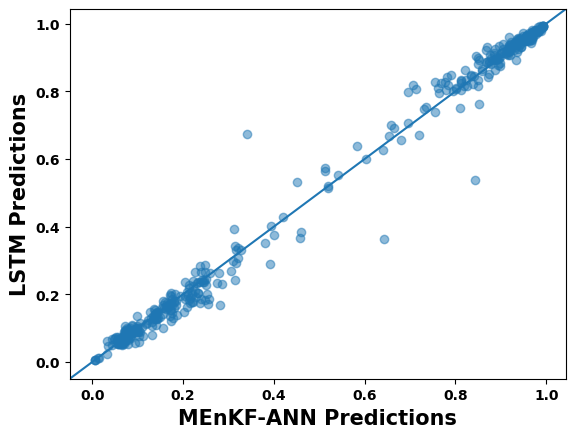

In [156]:
plt.scatter(enkf_preds,true_preds, alpha=0.5)
plt.xlabel("MEnKF-ANN Predictions", fontsize = 15, fontweight = "bold")
plt.ylabel("LSTM Predictions", fontsize = 15, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
plt.axline((0, 0), slope=1)
plt.show()

In [180]:
with open("Real_World_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'wb') as f:
    first_lstm = pickle.dump(catch_coverages, f)  

In [181]:
# check